# Computer Vision (CV) Data
> Classes and functions for handling images

In [ ]:
# default_exp cv.data

In [ ]:
# export
# Import packages and modules required for cv.data module
import matplotlib.pyplot as plt
import numpy as np
import os
import string

from pathlib import Path
from PIL import Image, ImageSequence
from PIL.TiffImagePlugin import TiffImageFile, TiffTags, ImageFileDirectory_v2
from typing import Any, Dict, List, Optional, Union

PathStr = Union[Path, str]

In [ ]:
# hide
# import packages and modules only required for running this notebook's examples
from nbdev.showdoc import show_doc
from tempfile import TemporaryDirectory

## Introduction to [TIFF](https://en.wikipedia.org/wiki/TIFF) Images
> The *Tag Image File Format* (TIFF or TIF) is a complex format ([full spec here](https://www.adobe.io/open/standards/TIFF.html)). In particular, each  TIFF file may contain several related images (**frames**) and additional information (**tags**) organized into an *Image File Directory* (**IFD**) structure. IFD uses a key-value format, similar to a python dictionnay - all keys are numbers. Many tags are predefined, such at the tags providing the image width, length, compression, ...
>
> The Class `TIFFImage` defined below handles commonly needed actions with TIFF such as retrieving tags values, adding new tags, exploring all the frames, extracting all or specific frames into separate image files ('tiff' or 'jpg').
>
> The module [`PIL.TiffImagePlugin`](https://pillow.readthedocs.io/en/stable/reference/plugins.html#module-PIL.TiffImagePlugin) offers a set of classes to easily handle TIFF, among which:
> - loading TIFF files and work with frames using [`TiffImageFile(path)`](https://pillow.readthedocs.io/en/stable/reference/plugins.html#PIL.TiffImagePlugin.TiffImageFile). It operates like [`Image`](https://pillow.readthedocs.io/en/stable/reference/Image.html) but with specific methods and properties for TIFF. For example, [`.seek(frame_nbr)`](https://pillow.readthedocs.io/en/stable/reference/plugins.html#PIL.TiffImagePlugin.TiffImageFile.seek) selects one of the frames and makes it active. After that, any action on the `TiffImageFile` object will apply to that particular frame. [`.n_frames`](https://pillow.readthedocs.io/en/stable/reference/plugins.html#PIL.TiffImagePlugin.TiffImageFile.n_frames) to get the total numer of frames in the file. It will inherit properties such as `size`, ...
> - IFD predefined tags can be accessed through [`PIL.TiffTags`](https://pillow.readthedocs.io/en/stable/reference/TiffTags.html#tifftags-module). 
> - Add new tags using the correct IFD structure with [`PIL.TiffImagePlugin.ImageFileDirectory_v2`](https://pillow.readthedocs.io/en/stable/reference/plugins.html?highlight=ImageFileDirectory_v2#PIL.TiffImagePlugin.ImageFileDirectory_v2).

In [ ]:
# load sample TIFF file from test image directory
p2tiff = Path('../test/img/tiff/tif-multi-frame-with-tags.tif').resolve()
tiff = TiffImageFile(p2tiff)

Display `n` frames from the loaded TIFF image file 

--- Frame 0 --------------------------------------------------------------------------------


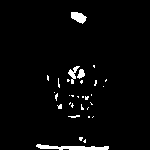

This frame has size (512, 512)
The image was loaded from /home/vtec/unpackai/test/img/tiff/tif-multi-frame-with-tags.tif
--- Frame 1 --------------------------------------------------------------------------------


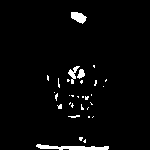

This frame has size (512, 512)
The image was loaded from /home/vtec/unpackai/test/img/tiff/tif-multi-frame-with-tags.tif
--- Frame 2 --------------------------------------------------------------------------------


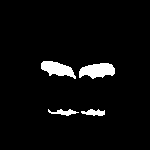

This frame has size (512, 512)
The image was loaded from /home/vtec/unpackai/test/img/tiff/tif-multi-frame-with-tags.tif


In [ ]:
n = 3
for frame in range(min(n, tiff.n_frames)):
    print(f"--- Frame {frame} {'-'*80}")
    display(tiff.resize((150,150)))
    tiff.seek(frame)
    print(f"This frame has size {tiff.size}")
    print(f"The image was loaded from {tiff.filename}")


Example of pre-defined tags and their desciption:

In [ ]:
predefined_tag_sublist = [256, 257, 259, 269, 270, 33432, 34665, 34675, 34853]
print(f"  Tag Nbr | Tag Name")
for tag_nbr in predefined_tag_sublist:
    print(f"  {tag_nbr:5d}   | {TiffTags.TAGS_V2[tag_nbr].name}")

  Tag Nbr | Tag Name
    256   | ImageWidth
    257   | ImageLength
    259   | Compression
    269   | DocumentName
    270   | ImageDescription
  33432   | Copyright
  34665   | ExifIFD
  34675   | ICCProfile
  34853   | GPSInfoIFD


It is possible to retrieve all existing tags to one frame. 
- `.tag_v2.keys()`, `.tag_v2.values()`, `.tag_v2.items()`, `.tag_v2.get(tag_nbr)` as in a dictionary
- `.ifd` to retrieve the entire Image File Directory. It behaves as a dictionary.
- `TiffTags.TAGS_V2` is a fixed dictionary that gives access to the predefined tags and their meanings

List of predefined tags in the loaded TIFF image:

In [ ]:
len(tiff.tag_v2.keys())

14

In [ ]:
tiff.seek(0)
tags_predefined = [tag for tag in tiff.tag_v2.keys() if tag in list(TiffTags.TAGS_V2.keys())]
[f"{tag:5d} - {TiffTags.TAGS_V2[tag].name:30s}:  {tiff.tag_v2.get(tag)}" for tag in tags_predefined]

['  256 - ImageWidth                    :  512',
 '  257 - ImageLength                   :  512',
 '  259 - Compression                   :  1',
 '  262 - PhotometricInterpretation     :  1',
 '  270 - ImageDescription              :  {"shape": [512, 512]}',
 '  273 - StripOffsets                  :  (320,)',
 '  277 - SamplesPerPixel               :  1',
 '  278 - RowsPerStrip                  :  512',
 '  279 - StripByteCounts               :  (32768,)',
 '  282 - XResolution                   :  1.0',
 '  283 - YResolution                   :  1.0',
 '  296 - ResolutionUnit                :  1',
 '  305 - Software                      :  tifffile.py']

List of custom tags in the loaded TIFF image:

In [ ]:
tags_custom = [tag for tag in tiff.tag_v2.keys() if tag not in list(TiffTags.TAGS_V2.keys())]
[f"{str(tag):38s}:  {tiff.tag_v2.get(tag)}" for tag in tags_custom]

['65001                                 :  Specular reflection']

## Class `TiffImage`

In [ ]:
# export
class TiffImage:
    """Load and handle TIFF images, such as viewing frames, extracting frames and saving them as single image files.
    
    TiffImage loads a TIFF image from a path (Path or str) and return a TiffImage object that:
    - gives access to the number of frames 'n_frames', all the tags 'tags' and the image size in pixel 'size'.
    - allows to return a specific frame as an object
    - allows to extract and save all or any frame as 'tif' or 'jpg image file(s)'
    - provides a __repr__ including information on each the frames in the image
    - allows to show thumbnails of all frames in a grid.
    
    Abreviations in the code are according to https://docs.fast.ai/dev/abbr.html
    
    """

    VALID_CHARS = f"-_.() {string.ascii_letters}{string.digits}"

    def __init__(self, path: PathStr):
        """Loads the TIFF image from system path"""
        self.path = self.handle_pathstr_(path)
        if self.path.suffix not in ['.tif', '.tiff']:
            raise ValueError(f"Image file should be .tif or .tiff, not '{self.path.suffix}'")
        self.tiff = TiffImageFile(self.path)
        
    def __repr__(self):
        """Return a summary of all the frames in the image file"""
        str_lst = [f"<unpackai.cv.data.TiffImage> TIFF image file with {self.n_frames} frames."]
        str_lst.append(f"  Loaded from {self.path}.")
        str_lst.append('  Frame Content Summary:')
        str_lst.append(f"    {'Frame':^7s}|{'Size':^15s}|{'Nbr Tags':^10s}")
        for i, frame in enumerate(ImageSequence.Iterator(self.tiff)):
            str_lst.append(f"    {str(i):^7s}|{str(frame.size):^15}|{str(len(frame.tag_v2.keys())):^10s}")
        str_lst.append(f"  To show image thumbnails, use method '.show(frame_nbr)' of '.show_all()'")
        txt = '\n'.join(str_lst)
        return txt

    def summary_tags(self, frame_nbr: int = 0):
        """Display a summary table of all the tags in the selected frame"""
        if self.is_valid_frame_(frame_nbr):
            self.tiff.seek(frame_nbr)
        tags_predefined = [tag for tag in self.tiff.tag_v2.keys() if tag in list(TiffTags.TAGS_V2.keys())]
        tags_custom = [tag for tag in self.tiff.tag_v2.keys() if tag not in list(TiffTags.TAGS_V2.keys())]

        str_lst = [f"|{'Tag Nbr':^9s}|{'Predefined Tag Name':^31s}|{'Tag Value':^70s} |"]
        str_lst.append(f"|{'=' * 112} |")
        str_lst.extend([f"|{str(tag):^9s}| {TiffTags.TAGS_V2[tag].name:<30s}| {str(self.tiff.tag_v2.get(tag))[:70]:<70s}|" for tag in tags_predefined])
        str_lst.extend([f"|{str(tag):^9s}| {' ':^30s}| {str(self.tiff.tag_v2.get(tag))[:70]:<70s}|" for tag in tags_custom])
        print('\n'.join(str_lst))
        
    def show(self, frame_nbr: int = 0):
        """Display a frame as a thumbnail"""
        if self.is_valid_frame_(frame_nbr):
            print(f"Showing frame {frame_nbr} out of {self.n_frames}:")
            self.tiff.seek(frame_nbr)
            plt.figure(figsize=(2, 2))
            plt.imshow(self.tiff)
            plt.axis('off')
            plt.show()

    def show_all(self, n_max: Optional[int] = None):
        """Display all frames (up to n_max) as a grid of thumbnails"""
        if n_max is None:
            n_max = self.n_frames
            print(f"Showing all {self.n_frames} frames:")
        else:
            n_max = min(n_max, self.n_frames)
            print(f"Showing {n_max} first frames of {self.n_frames}:")

        ncols = 6
        nrows = n_max//ncols + 1
        plt.figure(figsize=(14, 2 * nrows))
        for i in range(n_max):
            self.tiff.seek(i)
            plt.subplot(nrows, ncols, i+1)
            plt.imshow(self.tiff, cmap='Greys_r')
            plt.axis('off')
        plt.show()
            
    def get_frame(self, frame_nbr: int = 0) -> TiffImageFile:
        """Return the frame specified by 'frame_nbr' as an object
        
        The frame object is returned as a 'PIL.TiffImagePlugin.TiffImageFile' object. Which inherits from
        'PIL.Image.Image' and can be handled as a normal PIL image.
        """
        if self.is_valid_frame_(frame_nbr):
            self.tiff.seek(frame_nbr)
            return self.tiff

    def extract_frames(self, 
                       dest: Optional[PathStr] = None, 
                       naming_method: str = 'counter', 
                       tag: Optional[int] = None
                      ):
        
        """Extract each frame from the file and save them as individual TIFF image file
        
        All frames in the TIFF file are saved as independant TIFF image files.
        
        Two options for the individual image files:
         - 'counter':    original file + frame number suffix (frame number is 4-digit padded with zeros)
         - 'tag_value':  use the value in a specific tag, typycally when a class name is stored in a tag for each frame.
                         In case a `tag` value is not provided, the naming will revert to `counter`.
                         In case no tag is availaible in the frame for `tag`, the naming for that particular frame will
                         use the counter value instead for that frame.        
        """
        if tag is None:
            # todo: add warning here
            naming_method = 'counter'

        dest = self.handle_pathstr_(dest)
        
        for count, frame in enumerate(ImageSequence.Iterator(self.tiff)):
            ifd = frame.ifd
            if naming_method == 'counter':
                frame_slug = f"{count:04d}"
            elif naming_method == 'tag_value':
                if tag in list(frame.tag_v2.keys()):
                    tag_value = frame.tag_v2.get(tag)
                    frame_slug = ''.join(c for c in tag_value if c in self.VALID_CHARS).replace(' ', '_')
                else:
                    frame_slug = f"{count:04d}"
            else:
                raise ValueError(f"'naming_method' should be 'counter' or 'tag_value'")

            tiffpath = dest/f"{self.path.stem}-{frame_slug}.tif" 
            frame.save(tiffpath, tiffinfo=ifd)
    
    def extract_one_frame(self, 
                          frame_nbr: int = 0, 
                          image_format: str = 'jpg', 
                          dest: Optional[PathStr] = None,
                          fname: Optional[str] = None, 
                         ):
        """Extract the specified frame and save it as an image file of the specified format
        
        image_format: str   'tif' to save as a TIFF image, along with the frame IFD (tags)
                            'jpg' to save as a JPEG image, loosing the tag information
        dest: Path or str   destination directory where to save the image file
                            when not provided, the current working directory is selected by default
        fname: str          specific name for the image file
                            when not provided, the name will be the same as the original TIFF image file
                            name, with the frame number as sufix (4-digit padded with zeroes)
        
        """
        
        if image_format not in ['jpg', 'tif']:
            raise ValueError(f"'image_format' must be 'jpg' or 'tif', not '{image_format}'")
            
        dest = self.handle_pathstr_(dest)
        
        if self.is_valid_frame_(frame_nbr): 
            self.tiff.seek(frame_nbr)
            ifd = self.tiff.ifd
            frame_slug = f"{frame_nbr:04d}"
            if fname is None:
                fname = dest/f"{self.path.stem}-{frame_slug}.{image_format}" 
            else:
                fname = dest/f"{fname}.{image_format}"
            
            self.tiff.save(fname, tiffinfo=ifd)       
    
    @property
    def n_frames(self):
        """Number of frame in TIFF image file"""
        return self.tiff.n_frames
    
    @property
    def tags(self):
        """Dictionary with all tag-tag value pairs in the current frame"""
        return dict(self.tiff.tag_v2.items())
    
    @property
    def size(self):
        """Size of the current frame in pixel"""
        return self.tiff.size
        
    def is_valid_frame_(self, frame_nbr: int):
        """Internal utility method to validate that the requested frame exist for the current TIFF file"""
        if frame_nbr > self.n_frames:
            raise ValueError(f"'frame_nbr' is {frame_nbr} but this TIFF file only has {self.n_frames} frames. ")
        else:
            return True
    
    @staticmethod
    def handle_pathstr_(pathstr: PathStr):
        """Internal utility method to handle pathlib.Path or string as path and validate that the path exists"""
        if pathstr is None:
            pathstr = Path('')
        else:
            pathstr = Path(pathstr)
            if not pathstr.exists():
                raise FileExistsError(f"Cannot find path {pathstr}")
        return pathstr

## Examples

Create a new instance of `TiffImage` and display its default representation.

In [ ]:
tiff = TiffImage(p2tiff)
tiff

<unpackai.cv.data.TiffImage> TIFF image file with 8 frames.
  Loaded from /home/vtec/unpackai/test/img/tiff/tif-multi-frame-with-tags.tif.
  Frame Content Summary:
     Frame |     Size      | Nbr Tags 
       0   |  (512, 512)   |    14    
       1   |  (512, 512)   |    14    
       2   |  (512, 512)   |    14    
       3   |  (512, 512)   |    14    
       4   |  (512, 512)   |    14    
       5   |  (512, 512)   |    14    
       6   |  (512, 512)   |    14    
       7   |  (512, 512)   |    14    
  To show image thumbnails, use method '.show(frame_nbr)' of '.show_all()'

Explore the TIFF file frames

Showing frame 4 out of 8:


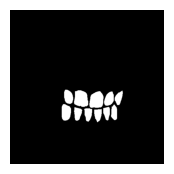

Showing all 8 frames:


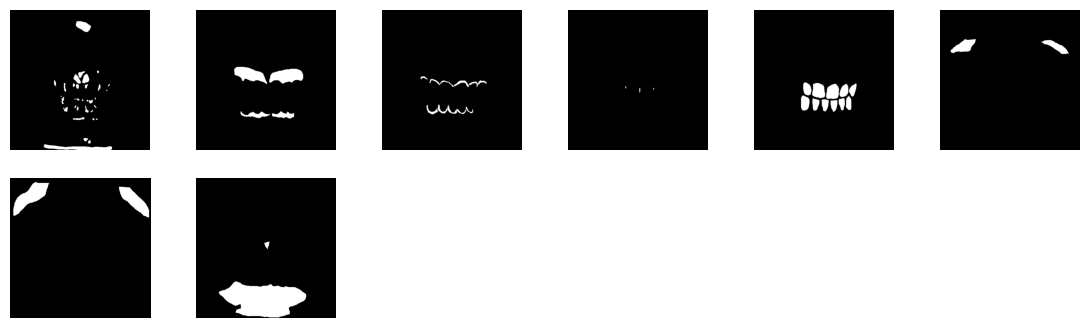

In [ ]:
tiff.show(4)
tiff.show_all()

Access the `TiffImage` properties:

In [ ]:
tiff.n_frames, tiff.size

(8, (512, 512))

In [ ]:
tiff.tags

{256: 512,
 257: 512,
 259: 1,
 262: 1,
 270: '{"shape": [512, 512]}',
 273: (231856,),
 277: 1,
 278: 512,
 279: (32768,),
 282: 1.0,
 283: 1.0,
 296: 1,
 65001: 'Oral mucosa',
 305: 'tifffile.py'}

In [ ]:
tiff.tags[65001]

'Oral mucosa'

Retrieve a specific frame as a `PIL.Image.Image` object

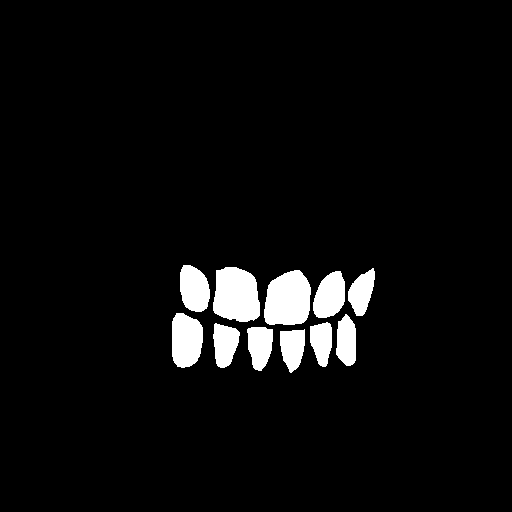

In [ ]:
tiff.get_frame(4)

In [ ]:
type(tiff.get_frame(0)), isinstance(tiff.get_frame(0), Image.Image)

(PIL.TiffImagePlugin.TiffImageFile, True)

Review all the tags for one frame

In [ ]:
tiff.summary_tags(0)

| Tag Nbr |      Predefined Tag Name      |                              Tag Value                                |
|================================================================================================================ |
|   256   | ImageWidth                    | 512                                                                   |
|   257   | ImageLength                   | 512                                                                   |
|   259   | Compression                   | 1                                                                     |
|   262   | PhotometricInterpretation     | 1                                                                     |
|   270   | ImageDescription              | {"shape": [512, 512]}                                                 |
|   273   | StripOffsets                  | (320,)                                                                |
|   277   | SamplesPerPixel               | 1                           

Extract one or several frames to be saved as 'jpg' or 'tif'

In [ ]:
with TemporaryDirectory() as tdir:
    p2dir = Path(tdir)
    print('Files in the temporary directory prior to extraction:')
    print('/n'.join([f" - {f.name}" for f in p2dir.iterdir()]))

    tiff.extract_one_frame(frame_nbr=2, dest=p2dir)
    tiff.extract_one_frame(frame_nbr=3, dest=p2dir, image_format='tif')
    tiff.extract_one_frame(frame_nbr=4, dest=p2dir, fname='specific-name')

    
    print('Files in the temporary directory after extraction:')
    print('\n'.join([f" - {f.name}" for f in p2dir.iterdir()]))

Files in the temporary directory prior to extraction:

Files in the temporary directory after extraction:
 - specific-name.jpg
 - tif-multi-frame-with-tags-0003.tif
 - tif-multi-frame-with-tags-0002.jpg


In [ ]:
with TemporaryDirectory() as tdir:
    p2dir = Path(tdir)
    print('Files in the temporary directory prior to extraction:')
    print('/n'.join([f" - {f.name}" for f in p2dir.iterdir()]))
    
    tiff.extract_frames(dest=p2dir, naming_method='counter')

    print('Files in the temporary directory after extraction:')
    print('\n'.join([f" - {f.name}" for f in p2dir.iterdir()]))

Files in the temporary directory prior to extraction:

Files in the temporary directory after extraction:
 - tif-multi-frame-with-tags-0000.tif
 - tif-multi-frame-with-tags-0004.tif
 - tif-multi-frame-with-tags-0006.tif
 - tif-multi-frame-with-tags-0005.tif
 - tif-multi-frame-with-tags-0003.tif
 - tif-multi-frame-with-tags-0001.tif
 - tif-multi-frame-with-tags-0002.tif
 - tif-multi-frame-with-tags-0007.tif


In [ ]:
with TemporaryDirectory() as tdir:
    p2dir = Path(tdir)
    print('Files in the temporary directory prior to extraction:')
    print('/n'.join([f" - {f.name}" for f in p2dir.iterdir()]))
    
    tiff.extract_frames(dest=p2dir, naming_method='tag_value', tag=65001)

    print('Files in the temporary directory after extraction:')
    print('\n'.join([f" - {f.name}" for f in p2dir.iterdir()]))

Files in the temporary directory prior to extraction:

Files in the temporary directory after extraction:
 - tif-multi-frame-with-tags-Hair.tif
 - tif-multi-frame-with-tags-Skin.tif
 - tif-multi-frame-with-tags-Specular_reflection.tif
 - tif-multi-frame-with-tags-Attached_gingiva.tif
 - tif-multi-frame-with-tags-Oral_mucosa.tif
 - tif-multi-frame-with-tags-Enamel.tif
 - tif-multi-frame-with-tags-Stain.tif
 - tif-multi-frame-with-tags-Marginal_gingiva.tif


# Tests

In [ ]:
# hide
# To be able to run the tests in the Notebook
from pathlib import Path
import ipytest
import sys

ipytest.autoconfig()

root_dir = Path("..").resolve()
sys.path.append(str(root_dir / "test"))

In [ ]:
# exportest
# For Test Cases (might have duplicate import because it will be in a dedicated file)
from pathlib import Path
from PIL import Image
from tempfile import TemporaryDirectory
from typing import List

import pytest

from test_common.utils_4_tests import DATA_DIR, IMG_DIR
from test_utils import GITHUB_TEST_DATA_URL, check_connection_github

In [ ]:
# exportest

tiff_fname = 'tif-multi-frame-with-tags.tif'
gif_fname = 'animated.gif'
LOCAL_TEST_TIFF = IMG_DIR / "tiff" / tiff_fname
LOCAL_TEST_GIF = IMG_DIR / "tiff" / gif_fname

LOCAL_TEST_SUMMARY_TAGS = DATA_DIR / 'tiff_summary_tags.txt'
LOCAL_TEST_REPR = DATA_DIR / 'tiff_repr.txt'

GITHUB_TEST_IMG_DIR_URL = "https://raw.githubusercontent.com/unpackAI/unpackai/main/test/img"
GITHUB_TEST_TIFF = f"{GITHUB_TEST_IMG_DIR_URL}/tiff/{tiff_fname}"
GITHUB_TEST_GIF = f"{GITHUB_TEST_IMG_DIR_URL}/tiff/{gif_fname}"

def test_exception_on_missing_path():
    with pytest.raises(FileExistsError) as msg:
        TiffImage('blabla.tif')
    expected_msg = f"Cannot find path {'blabla.tif'}"
    assert str(msg.value) == expected_msg
        
def test_exception_on_wrong_suffix():
    with pytest.raises(ValueError) as msg:
        TiffImage(IMG_DIR/'tiff'/gif_fname)
    expected_msg = f"Image file should be .tif or .tiff, not '{'.gif'}'"
    assert str(msg.value) == expected_msg

@pytest.fixture(scope="session")
def test_tiff_image():
    """Fixture to pass the test TIFF image path"""
    return LOCAL_TEST_TIFF

@pytest.fixture(scope="session")
def test_repr():
    return LOCAL_TEST_REPR.read_text()

@pytest.fixture(scope="session")
def test_summary_tag_printout():
    return LOCAL_TEST_SUMMARY_TAGS.read_text()

@pytest.fixture(scope="session")
def local_TiffImage(test_tiff_image):
    """Create instance of TiffImage by loading the test TIFF image"""
    return TiffImage(test_tiff_image)

class Test_TiffImage:
    """Testing class for TiffImage"""
       
    def test_n_frames(self, local_TiffImage):
        """Test property n_frame"""
        expected_value = 8
        assert local_TiffImage.n_frames == expected_value
        
    def test_size(self, local_TiffImage):
        """Test property Size"""
        expected_value = (512, 512)
        assert local_TiffImage.size == expected_value
        
    def test_tags(self, local_TiffImage):
        """Test returned dictionary"""
        expected_value_0 = {256: 512, 257: 512, 259: 1, 262: 1, 270: '{"shape": [512, 512]}', 
                            273: (320,), 277: 1, 278: 512, 279: (32768,), 282: 1.0, 283: 1.0, 296: 1,
                            65001: 'Specular reflection',
                            305: 'tifffile.py'}
        expected_value_1 = {256: 512, 257: 512, 259: 1, 262: 1, 270: '{"shape": [512, 512]}',
                            273: (33408,), 277: 1, 278: 512, 279: (32768,), 282: 1.0, 283: 1.0, 296: 1, 
                            65001: 'Attached gingiva', 
                            305: 'tifffile.py'}
        local_TiffImage.tiff.seek(0)
        assert local_TiffImage.tags == expected_value_0
        local_TiffImage.tiff.seek(1)
        assert local_TiffImage.tags == expected_value_1
    
    def test_repr(self, local_TiffImage, capsys, test_repr):
        """Test the __repr__"""
        expected_value = test_repr
        local_TiffImage.tiff.seek(0)
        print(local_TiffImage)
        captured = capsys.readouterr()
        assert captured.out == expected_value
        
    def test_summary_tags_printout(self, local_TiffImage, capsys, test_summary_tag_printout):
        """Test the tag summary method"""        
        expected_value = test_summary_tag_printout
        local_TiffImage.tiff.seek(0)
        local_TiffImage.summary_tags()
        captured = capsys.readouterr()
        assert captured.out == expected_value
        
    def test_type_returned_by_get_frame(self, local_TiffImage):
        """Test that object is 'PIL.TiffImagePlugin.TiffImageFile'"""
        frame = local_TiffImage.get_frame(0)
        assert isinstance(frame, TiffImageFile)
        
    def test_extract_one_frame(self, local_TiffImage):
        """Test that frames are extracted and saved"""
        with TemporaryDirectory() as tdir:
            p2dir = Path(tdir)        
            tiff.extract_one_frame(frame_nbr=2, dest=p2dir)
            assert (p2dir / 'tif-multi-frame-with-tags-0002.jpg').is_file()
            tiff.extract_one_frame(frame_nbr=3, dest=p2dir, image_format='tif')
            assert (p2dir / 'tif-multi-frame-with-tags-0003.tif').is_file()
            tiff.extract_one_frame(frame_nbr=4, dest=p2dir, fname='specific-name')
            assert (p2dir / 'specific-name.jpg').is_file()

    def test_extract_frames_by_tag(self, local_TiffImage):
        """Test that all frames are saved and naming by tag is correct """
        with TemporaryDirectory() as tdir:
            p2dir = Path(tdir)        
            tiff.extract_frames(dest=p2dir, naming_method='tag_value', tag=65001)
            assert (p2dir / 'tif-multi-frame-with-tags-Hair.tif').is_file()
            assert (p2dir / 'tif-multi-frame-with-tags-Skin.tif').is_file()
            assert (p2dir / 'tif-multi-frame-with-tags-Stain.tif').is_file()
            assert (p2dir / 'tif-multi-frame-with-tags-Marginal_gingiva.tif').is_file()
            assert len(list(p2dir.iterdir())) == local_TiffImage.n_frames

    def test_extract_frames_by_nbr(self, local_TiffImage):
        """Test that all frames are saved and naming by number is correct """
        with TemporaryDirectory() as tdir:
            p2dir = Path(tdir)        
            tiff.extract_frames(dest=p2dir)
            assert (p2dir / 'tif-multi-frame-with-tags-0001.tif').is_file()
            assert (p2dir / 'tif-multi-frame-with-tags-0002.tif').is_file()
            assert (p2dir / 'tif-multi-frame-with-tags-0005.tif').is_file()
            assert (p2dir / 'tif-multi-frame-with-tags-0007.tif').is_file()
            assert len(list(p2dir.iterdir())) == local_TiffImage.n_frames

    def test_is_valid_frame_(self, local_TiffImage):
        nframes = local_TiffImage.n_frames
        assert local_TiffImage.is_valid_frame_(0)
        with pytest.raises(ValueError) as msg:
            local_TiffImage.is_valid_frame_(nframes + 1)
        expected_msg = f"'frame_nbr' is {nframes+1} but this TIFF file only has {nframes} frames."
        assert str(msg.value)[:-1] == expected_msg

In [ ]:
# hide
ipytest.run()

............                                                                                 [100%]
12 passed in 0.09s
